## Example from github

In [25]:
import numpy as np
import tensorflow as tf

from keras import Model, layers, optimizers, losses, metrics

from keras_gcnn.layers import GConv2D, GBatchNorm, GroupPool

In [26]:
# Define model with functional API:
ip = layers.Input(shape=(128, 128, 3))
x = GConv2D(8, h_input='Z2', h_output='D4', kernel_size=5, padding='same')(ip)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = GConv2D(16, h_input='D4', h_output='D4', kernel_size=3, padding='same')(x)
x = GBatchNorm(h='D4')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = GConv2D(32, h_input='D4', h_output='D4', kernel_size=3, padding='same')(x)
x = GBatchNorm(h='D4')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)

x = GConv2D(1, h_input='D4', h_output='D4', kernel_size=3, padding='same')(x)
x = GroupPool('D4')(x)
model = Model(inputs=ip, outputs=x)

# Generate random test image:
img = np.random.randn(128, 128, 3)

# Run a forward pass through the model with the image and transformed images:
res = model.predict(
    np.stack([img, np.rot90(img), np.rot90(np.fliplr(img), 2)]),
    batch_size=1,
)

# Test that activations are the same:
assert np.allclose(res[0], np.rot90(res[1], 3), rtol=1e-5, atol=1e-3)
assert np.allclose(res[0], np.flipud(res[2]), rtol=1e-5, atol=1e-3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [27]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_36 (GConv2D)           │ (None, 128, 128, 64)   │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_37 (GConv2D)           │ (None, 64, 64, 128)    │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_28 (GBatchNorm)    │ (None, 64, 64, 128)    │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_38 (GConv2D)           │ (None, 32, 32, 256)    │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_29 (GBatchNorm)    │ (None, 32, 32, 256)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_39 (GConv2D)           │ (None, 16, 16, 8)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_12 (GroupPool)       │ (None, 16, 16, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,176 (192.09 KB)

 Trainable params: 49,080 (191.72 KB)

 Non-trainable params: 96 (384.00 B)

## Cohen Experiment from 2016

In [28]:
# Load data and preprocess

import os
from gconv_experiment.train import preprocess_mnist_data

datadir = './data/mnist/'
trainfn = 'train_all.npz'
valfn = 'test.npz'

train_set = np.load(os.path.join(datadir, trainfn))
val_set = np.load(os.path.join(datadir, valfn))
train_data = train_set['data']
train_labels = train_set['labels']
val_data = val_set['data']
val_labels = val_set['labels']

train_data, val_data, train_labels, val_labels = preprocess_mnist_data(train_data, val_data, train_labels, val_labels)


print(f"training {train_data.shape} {train_labels.shape} \n validation {val_data.shape} {val_labels.shape}")

training (12000, 28, 28, 1) (12000,) 
 validation (50000, 28, 28, 1) (50000,)


### Z2CNN

In [29]:
# Define Model
def make_z2cnn():
    dr = 0.3
    ip = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(20, kernel_size=3)(ip)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x)

    for i in range(2, 7):
        x = layers.Conv2D(20, kernel_size=3)(x)
        x = layers.Activation('relu')(x)
        x = layers.BatchNormalization()(x)

        if i == 2:
            x = layers.MaxPooling2D()(x)
        else:
            x = layers.Dropout(dr)(x)

    x = layers.Conv2D(10, kernel_size=4)(x)

    x = layers.GlobalMaxPool2D()(x)

    return Model(inputs=ip, outputs=x)

z2cnn = make_z2cnn()
z2cnn.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 20)     │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 26, 26, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 24, 24, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 10, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 20)       │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 6, 6, 20)       │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 6, 6, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 6, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 6, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 20)       │         3,620 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,990 (85.90 KB)

 Trainable params: 21,750 (84.96 KB)

 Non-trainable params: 240 (960.00 B)

In [30]:
single_idx = 10
label = train_labels[single_idx]
prediction = z2cnn.predict(train_data)[single_idx].argmax()
print(f"predicted {prediction} for datum with label {label}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
predicted 2 for datum with label 3


### P4CNN

In [31]:
def make_p4cnn():
    # Define Model
    dr = 0.3
    ip = layers.Input(shape=(28, 28, 1))
    x = GConv2D(10, kernel_size=3, h_input='Z2', h_output='C4')(ip)
    x = layers.Activation('relu')(x)
    x = GBatchNorm(h='C4')(x)
    x = layers.Dropout(dr)(x)

    for i in range(2, 7):
        x = GConv2D(10, kernel_size=3, h_input='C4', h_output='C4')(x)
        x = layers.Activation('relu')(x)
        x = GBatchNorm('C4')(x)

        if i == 2:
            x = layers.MaxPooling2D()(x)
        else:
            x = layers.Dropout(dr)(x)

    x = GConv2D(10, kernel_size=4, h_input='C4', h_output='C4')(x)

    x = GroupPool('C4')(x)
    x = layers.GlobalMaxPool2D()(x)

    return Model(inputs=ip, outputs=x)

p4cnn = make_p4cnn()
p4cnn.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_40 (GConv2D)           │ (None, 26, 26, 40)     │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 26, 26, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_30 (GBatchNorm)    │ (None, 26, 26, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 26, 26, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_41 (GConv2D)           │ (None, 24, 24, 40)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_31 (GBatchNorm)    │ (None, 24, 24, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_42 (GConv2D)           │ (None, 10, 10, 40)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 10, 10, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_32 (GBatchNorm)    │ (None, 10, 10, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10, 10, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_43 (GConv2D)           │ (None, 8, 8, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_33 (GBatchNorm)    │ (None, 8, 8, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_44 (GConv2D)           │ (None, 6, 6, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 6, 6, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_34 (GBatchNorm)    │ (None, 6, 6, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 6, 6, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_45 (GConv2D)           │ (None, 4, 4, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 4, 4, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_35 (GBatchNorm)    │ (None, 4, 4, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4, 4, 40)       │             

 Total params: 24,730 (96.60 KB)

 Trainable params: 24,610 (96.13 KB)

 Non-trainable params: 120 (480.00 B)

In [32]:
single_idx = 10
label = train_labels[single_idx]
prediction = p4cnn.predict(train_data)[single_idx].argmax()
print(f"predicted {prediction} for datum with label {label}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
predicted 0 for datum with label 3


In [33]:
tf.int32

tf.int32

In [34]:
predictions = p4cnn.predict(val_data)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [35]:
predicted = 0
for i in range(len(val_data)):
    print(val_labels[i], predictions[i].argmax())
    
    if int(val_labels[i]) == int(predictions[i].argmax()):
        predicted += 1

6 5
0 0
6 5
2 5
6 5
7 5
6 5
2 5
1 5
1 0
4 5
0 5
7 5
7 5
3 0
8 5
5 5
6 0
9 5
1 0
6 5
9 5
8 5
9 5
9 5
1 5
4 0
8 5
5 5
6 0
5 5
1 5
0 5
5 0
4 5
8 0
8 0
3 5
2 5
0 0
9 5
9 5
0 0
5 0
6 5
1 5
3 5
1 0
1 5
0 5
7 5
8 0
5 5
3 0
5 5
4 0
8 5
4 5
0 0
2 5
2 5
5 5
1 0
0 0
9 5
4 5
7 5
6 5
7 5
9 5
0 5
3 0
5 5
7 5
3 0
9 5
6 5
3 5
6 5
2 0
1 5
8 0
1 0
2 5
2 0
4 5
9 5
9 5
7 0
7 5
7 5
0 5
9 5
3 5
0 0
7 5
5 5
7 5
1 0
8 0
1 5
7 5
1 5
0 5
3 0
4 5
4 5
0 5
3 0
1 5
1 5
5 5
0 0
2 0
9 0
2 5
4 5
8 0
6 5
6 5
6 5
7 5
4 0
9 5
7 5
7 5
5 0
3 5
3 5
1 5
6 5
2 5
3 0
2 5
4 5
7 5
4 0
1 0
9 0
7 5
7 5
0 0
7 5
4 5
5 0
1 5
1 5
1 5
9 5
7 5
8 0
9 5
8 5
0 5
3 0
8 5
6 0
2 5
3 0
2 5
0 5
6 5
2 0
0 0
4 5
6 0
6 5
0 5
0 5
0 5
9 5
9 5
7 0
6 5
5 0
0 5
1 5
5 5
8 5
3 5
1 5
9 5
9 5
4 5
6 5
8 5
5 0
5 5
4 5
1 5
2 5
6 5
5 5
7 5
7 5
6 5
7 0
8 5
3 5
2 0
2 5
5 5
5 5
2 0
2 5
6 5
2 5
2 5
4 5
9 0
7 5
1 5
8 5
8 5
0 5
2 5
5 5
3 5
7 5
6 5
0 5
4 5
5 0
5 5
3 5
8 5
8 5
7 5
0 5
0 0
4 5
1 5
2 5
3 0
8 5
2 0
4 5
9 5
9 5
0 0
0 0
4 5
8 5
5 5
8 5
7 5
8 5
7 5
7 0
0 0


In [36]:
predicted / len(val_labels)

0.09802

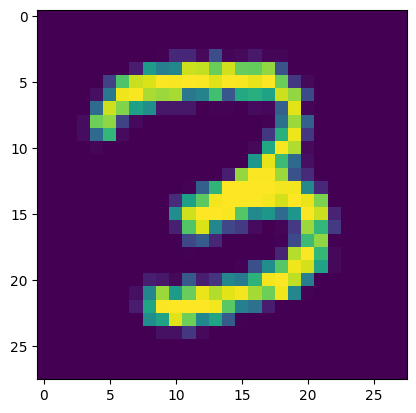

In [37]:
import matplotlib.pyplot as plt
plt.imshow(train_data[9])

### P4CNN No Dropout

In [38]:
def make_p4cnn_nodrop():
    # Define Model
    dr = 0.3
    ip = layers.Input(shape=(28, 28, 1))
    x = GConv2D(10, kernel_size=3, h_input='Z2', h_output='C4')(ip)
    x = layers.Activation('relu')(x)
    x = GBatchNorm(h='C4')(x)
    # x = layers.Dropout(dr)(x)

    for i in range(2, 7):
        x = GConv2D(10, kernel_size=3, h_input='C4', h_output='C4')(x)
        x = layers.Activation('relu')(x)
        x = GBatchNorm('C4')(x)

        if i == 2:
            x = layers.MaxPooling2D()(x)
        # else:
        #     x = layers.Dropout(dr)(x)

    x = GConv2D(10, kernel_size=4, h_input='C4', h_output='C4')(x)

    x = GroupPool('C4')(x)
    x = layers.GlobalMaxPool2D()(x)

    return Model(inputs=ip, outputs=x)

p4cnn_nodrop = make_p4cnn_nodrop()
p4cnn_nodrop.summary()
p4cnn_nodrop.compile(optimizer=optimizers.Adam(),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[metrics.sparse_categorical_accuracy])

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_47 (GConv2D)           │ (None, 26, 26, 40)     │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 26, 26, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_36 (GBatchNorm)    │ (None, 26, 26, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_48 (GConv2D)           │ (None, 24, 24, 40)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 24, 24, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_37 (GBatchNorm)    │ (None, 24, 24, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_49 (GConv2D)           │ (None, 10, 10, 40)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 10, 10, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_38 (GBatchNorm)    │ (None, 10, 10, 40)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_50 (GConv2D)           │ (None, 8, 8, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 8, 8, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_39 (GBatchNorm)    │ (None, 8, 8, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_51 (GConv2D)           │ (None, 6, 6, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 6, 6, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_40 (GBatchNorm)    │ (None, 6, 6, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_52 (GConv2D)           │ (None, 4, 4, 40)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 4, 4, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_41 (GBatchNorm)    │ (None, 4, 4, 40)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_53 (GConv2D)           │ (None, 1, 1, 40)       │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_14 (GroupPool)       │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_8          │ (None, 10)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,730 (96.60 KB)

 Trainable params: 24,610 (96.13 KB)

 Non-trainable params: 120 (480.00 B)

### P4CNN with Rotation Pooling

In [ ]:
def make_p4cnn_rotpool():
    # Define Model
    dr = 0.3
    ip = layers.Input(shape=(28, 28, 1))
    x = GConv2D(20, kernel_size=3, h_input='Z2', h_output='C4')(ip)
    x = layers.Activation('relu')(x)
    x = GBatchNorm(h='C4')(x)
    x = GroupPool('C4')(x)
    x = layers.Dropout(dr)(x)

    for i in range(2, 7):
        x = GConv2D(20, kernel_size=3, h_input='Z2', h_output='C4')(x)
        x = layers.Activation('relu')(x)
        x = GBatchNorm('C4')(x)
        x = GroupPool('C4')(x)

        if i == 2:
            x = layers.MaxPooling2D()(x)
        else:
            x = layers.Dropout(dr)(x)

    x = GConv2D(10, kernel_size=4, h_input='Z2', h_output='C4')(x)
    x = GroupPool('C4')(x)
    x = layers.GlobalMaxPool2D()(x)

    return Model(inputs=ip, outputs=x)

p4cnn_rotpool = make_p4cnn_rotpool()
p4cnn_rotpool.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_54 (GConv2D)           │ (None, 26, 26, 80)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 26, 26, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_42 (GBatchNorm)    │ (None, 26, 26, 80)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_15 (GroupPool)       │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 26, 26, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_55 (GConv2D)           │ (None, 24, 24, 80)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 24, 24, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_43 (GBatchNorm)    │ (None, 24, 24, 80)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_16 (GroupPool)       │ (None, 24, 24, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_56 (GConv2D)           │ (None, 10, 10, 80)     │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 10, 10, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_44 (GBatchNorm)    │ (None, 10, 10, 80)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_17 (GroupPool)       │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_57 (GConv2D)           │ (None, 8, 8, 80)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 8, 8, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_45 (GBatchNorm)    │ (None, 8, 8, 80)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_18 (GroupPool)       │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_conv2d_58 (GConv2D)           │ (None, 6, 6, 80)       │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 6, 6, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_batch_norm_46 (GBatchNorm)    │ (None, 6, 6, 80)       │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pool_19 (GroupPool)       │ (None, 6, 6, 20)       │             

 Total params: 21,860 (85.39 KB)

 Trainable params: 21,620 (84.45 KB)

 Non-trainable params: 240 (960.00 B)

: 

### Run all experiments

In [ ]:
import csv
import time

starttime = time.time()

models = {
    "z2": make_z2cnn,
    "p4": make_p4cnn,
    "p4nodrop": make_p4cnn_nodrop,
    "p4rotpool":make_p4cnn_rotpool,
}

epochs = 100
repeats = 90

results = {"model": [],"loss":[], "accuracy":[]}

for i in range(repeats):
    tf.random.set_seed(i)
    for key in models:
        model = models[key]()
        model.compile(
            optimizer=optimizers.Adam(),
            loss=losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[metrics.sparse_categorical_accuracy]
        )
        model.fit(train_data,
          train_labels,
          epochs=epochs if key != 'z2' else (epochs * 3),
          batch_size=128,
          validation_split=2/12,
          verbose=0
          )
        loss, accuracy = model.evaluate(val_data, val_labels,
                                        batch_size=1000,
                                        verbose=0,
                                        )

        results["model"].append(key)
        results["loss"].append(loss)
        results["accuracy"].append(accuracy)

        del model

with open("mnist_rot" + str(starttime) + ".txt", "a") as file:
                   
            f = csv.writer(file)
            for i in range(len(results["loss"])):
                f.writerow([results["model"][i],
                            results["loss"][i],
                            results["accuracy"][i]])

In [ ]:
starttime

1742855871.0426414

In [ ]:
accuracy = {"z2":[], "p4":[], "p4nodrop":[], "p4rotpool":[]}
with open("mnist_rot.txt", "r") as file:
    f = csv.DictReader(file)
    for line in f:
        accuracy[line["model"]].append(line[" accuracy"])
 
for model, acc in accuracy.items():
    acc = [float(x) for x in acc]
    print(model, sum(acc) / 10)

z2 0.9488960027694702
p4 0.9721239984035492
p4nodrop 0.9629340052604676
p4rotpool 0.9598560035228729
